# DSCI 100 Project Proposal

## Introduction

Heart disease is a growing issue in the 21st century which demands early methods of diagnosis. As such, computerized data models are viewed as an indispensable tool in a diagnostician's tool box. One promising application of this technology is in diagnosing patients years before they show symptoms. This may prevent many premature deaths and provide a higher quality of life for patients through early treatment. 

Consequently, this project aims to build a data model that can determine heart disease in patients from collected health data. This model will be trained using the Heart Disease dataset collected from the UCL Machine Learning Repository. The data collected from patients includes basic identification info such as age as well as hereditary disease information such as Thalassemia. In the following sections, this data will be explored to understand how it contributes to determining heart disease.

## Preliminary Exploratory Data Analysis

First we read the data from the repository and import libraries 

In [1]:
library(repr)
library(tidyverse) 
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [6]:
# un-comment to download the data
download.file(url = "https://github.com/Oscar-Yik/dsci-100-project/blob/3af4ff02686b68be2b21e76b3c5c68ec408c329f/data/heart_disease/processed.cleveland.data", destfile = "data/heart_disease/processed.cleveland.data")
download.file(url = "https://github.com/Oscar-Yik/dsci-100-project/blob/3af4ff02686b68be2b21e76b3c5c68ec408c329f/data/heart_disease/processed.hungarian.data", destfile = "data/heart_disease/processed.hungarian.data")
download.file(url = "https://github.com/Oscar-Yik/dsci-100-project/blob/3af4ff02686b68be2b21e76b3c5c68ec408c329f/data/heart_disease/processed.switzerland.data", destfile = "data/heart_disease/processed.switzerland.data")
download.file(url = "https://github.com/Oscar-Yik/dsci-100-project/blob/3af4ff02686b68be2b21e76b3c5c68ec408c329f/data/heart_disease/processed.va.data", destfile = "data/heart_disease/processed.va.data")

In [2]:
heart_disease_cols <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_disease_C <- read_csv(file = "data/heart_disease/processed.cleveland.data", col_names = heart_disease_cols)
heart_disease_H <- read_csv(file = "data/heart_disease/processed.hungarian.data", col_names = heart_disease_cols)
heart_disease_S <- read_csv(file = "data/heart_disease/processed.switzerland.data", col_names = heart_disease_cols)
heart_disease_V <- read_csv(file = "data/heart_disease/processed.va.data", col_names = heart_disease_cols)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to retr

We will replace missing values with their most frequent value.

In [3]:
find_most_frequent <- function(data, column, column_str) {
    result <- data |> 
        mutate(across(all_of(c({{ column_str }})), ~na_if(., "?"))) |> 
        filter(!is.na({{ column }})) |>
        group_by({{ column }}) |> 
        summarize(count = n()) |>
        slice_max(count,n=1) |> 
        pull({{ column }})
    return(result)
}

impute_feat <- function(data, column) {
    column_str = deparse(substitute(column))
    result <- data |>
        mutate(across(all_of(c({{ column_str }})), ~na_if(., "?"))) |> 
        mutate({{column}} := if_else(is.na({{column}}), find_most_frequent(data, {{column}}, {{column_str}}) , {{column}}))
    return(result)
}

impute_feat_special <- function(data, column) {
    column_str = deparse(substitute(column))
    result <- data |>
        mutate(across(all_of(c({{ column_str }})), ~na_if(., "?"))) |> 
        mutate({{column}} := if_else(is.na({{column}}), find_most_frequent(data, {{column}}, {{column_str}})[[1]] , {{column}}))
    return(result)
}

# imputation <- function(data) {
#     cc <- names(heart_disease_V)[map_lgl(heart_disease_V, is.character)]
#     # for (cname in cc) {
#     #     print(as.name(cname))
#     #     result <- impute_feat(data, as.name(cname))
#     # }
#     print(cc)
#     # result <- data |> 
#     #     # mutate(across(where(is.character), ~impute_feat(data, {{ .col }})))
#     #     mutate(across(where(is.character), ~test(data, {{ .col }})))
#     return(result)
# }
# heart_disease_V <- imputation(heart_disease_V)

heart_disease_C <- impute_feat(heart_disease_C, ca)
heart_disease_C <- impute_feat(heart_disease_C, thal)

heart_disease_H <- impute_feat(heart_disease_H, ca)
heart_disease_H <- impute_feat(heart_disease_H, thal)
heart_disease_H <- impute_feat(heart_disease_H, trestbps)
heart_disease_H <- impute_feat_special(heart_disease_H, chol)
heart_disease_H <- impute_feat(heart_disease_H, fbs)
heart_disease_H <- impute_feat(heart_disease_H, thalach)
heart_disease_H <- impute_feat(heart_disease_H, exang)
heart_disease_H <- impute_feat(heart_disease_H, restecg)
heart_disease_H <- impute_feat(heart_disease_H, slope)

heart_disease_S <- impute_feat(heart_disease_S, ca)
heart_disease_S <- impute_feat(heart_disease_S, thal)
heart_disease_S <- impute_feat(heart_disease_S, trestbps)
heart_disease_S <- impute_feat(heart_disease_S, fbs)
heart_disease_S <- impute_feat(heart_disease_S, thalach)
heart_disease_S <- impute_feat(heart_disease_S, exang)
heart_disease_S <- impute_feat(heart_disease_S, restecg)
heart_disease_S <- impute_feat(heart_disease_S, oldpeak)
heart_disease_S <- impute_feat(heart_disease_S, slope)

heart_disease_V <- impute_feat(heart_disease_V, ca)
heart_disease_V <- impute_feat(heart_disease_V, thal)
heart_disease_V <- impute_feat(heart_disease_V, trestbps)
heart_disease_V <- impute_feat(heart_disease_V, chol)
heart_disease_V <- impute_feat(heart_disease_V, fbs)
heart_disease_V <- impute_feat_special(heart_disease_V, thalach)
heart_disease_V <- impute_feat(heart_disease_V, exang)
heart_disease_V <- impute_feat(heart_disease_V, oldpeak)
heart_disease_V <- impute_feat(heart_disease_V, slope)
heart_disease_C
heart_disease_H
heart_disease_S
heart_disease_V

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,0.0,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,2,0,7,0
29,1,2,120,243,0,0,160,0,0,2,0,7,0
29,1,2,140,230,0,0,170,0,0,2,0,7,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,0,7,1
58,0,2,180,393,0,0,110,1,1,2,0,7,1
65,1,4,130,275,0,1,115,1,1,2,0,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
32,1,1,95,0,0,0,127,0,.7,1,2,7,1
34,1,4,115,0,0,0,154,0,.2,1,2,7,1
35,1,4,115,0,0,0,130,1,0,2,2,7,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,0,2,114,0,1.6,2,2,7,0
73,0,3,160,0,0,1,121,0,0,1,2,3,1
74,1,2,145,0,0,1,123,0,1.3,1,2,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
63,1,4,140,260,0,1,112,1,3,2,0,7,2
44,1,4,130,209,0,1,127,0,0,2,0,7,0
60,1,4,132,218,0,1,140,1,1.5,3,0,7,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,2,0,6,2
58,1,4,120,385,1,2,120,1,0,2,0,7,0
62,1,2,120,254,0,2,93,1,0,2,0,7,1


We need to correct the data types of all features

In [4]:
# Factor: sex, cp, fbs, restecg, exang, slope, thal, num
correct_types <- function(data) {
    result <- data |> 
        mutate(sex = as_factor(sex)) |> 
        mutate(cp = as_factor(cp)) |> 
        mutate(fbs = as_factor(fbs)) |> 
        mutate(restecg = as_factor(restecg)) |> 
        mutate(exang = as_factor(exang)) |> 
        mutate(slope = as_factor(slope)) |>
        mutate(thal = as_factor(thal)) |> 
        mutate(ca = as.numeric(ca)) |>
        mutate(age = as.numeric(age)) |>
        mutate(trestbps = as.numeric(trestbps)) |>
        mutate(chol = as.numeric(chol)) |> 
        mutate(oldpeak = as.numeric(oldpeak))
    return(result)
}

heart_disease_C <- correct_types(heart_disease_C)
heart_disease_H <- correct_types(heart_disease_H)
heart_disease_S <- correct_types(heart_disease_S)
heart_disease_V <- correct_types(heart_disease_V)
heart_disease_C
heart_disease_H
heart_disease_S
heart_disease_V

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,0,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
28,1,2,130,132,0,2,185,0,0,2,0,7,0
29,1,2,120,243,0,0,160,0,0,2,0,7,0
29,1,2,140,230,0,0,170,0,0,2,0,7,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,0,7,1
58,0,2,180,393,0,0,110,1,1,2,0,7,1
65,1,4,130,275,0,1,115,1,1,2,0,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
32,1,1,95,0,0,0,127,0,0.7,1,2,7,1
34,1,4,115,0,0,0,154,0,0.2,1,2,7,1
35,1,4,115,0,0,0,130,1,0.0,2,2,7,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,0,2,114,0,1.6,2,2,7,0
73,0,3,160,0,0,1,121,0,0.0,1,2,3,1
74,1,2,145,0,0,1,123,0,1.3,1,2,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
63,1,4,140,260,0,1,112,1,3.0,2,0,7,2
44,1,4,130,209,0,1,127,0,0.0,2,0,7,0
60,1,4,132,218,0,1,140,1,1.5,3,0,7,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,2,0,6,2
58,1,4,120,385,1,2,120,1,0,2,0,7,0
62,1,2,120,254,0,2,93,1,0,2,0,7,1


The target column will be renamed with all values greater than 0 changed to 1.

In [5]:
convert_target <- function(data) {
    result <- data |>
        mutate(num = if_else(num > 0, 1, 0)) |>
        mutate(num = as.factor(num)) |>
        rename(not_healthy = num)
    return(result)
}

heart_disease_C <- convert_target(heart_disease_C)
heart_disease_H <- convert_target(heart_disease_H)
heart_disease_S <- convert_target(heart_disease_S)
heart_disease_V <- convert_target(heart_disease_V)
heart_disease_C
heart_disease_H
heart_disease_S
heart_disease_V

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,not_healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,0,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,not_healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
28,1,2,130,132,0,2,185,0,0,2,0,7,0
29,1,2,120,243,0,0,160,0,0,2,0,7,0
29,1,2,140,230,0,0,170,0,0,2,0,7,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,0,7,1
58,0,2,180,393,0,0,110,1,1,2,0,7,1
65,1,4,130,275,0,1,115,1,1,2,0,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,not_healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
32,1,1,95,0,0,0,127,0,0.7,1,2,7,1
34,1,4,115,0,0,0,154,0,0.2,1,2,7,1
35,1,4,115,0,0,0,130,1,0.0,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,0,2,114,0,1.6,2,2,7,0
73,0,3,160,0,0,1,121,0,0.0,1,2,3,1
74,1,2,145,0,0,1,123,0,1.3,1,2,7,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,not_healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,1,4,140,260,0,1,112,1,3.0,2,0,7,1
44,1,4,130,209,0,1,127,0,0.0,2,0,7,0
60,1,4,132,218,0,1,140,1,1.5,3,0,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,2,0,6,1
58,1,4,120,385,1,2,120,1,0,2,0,7,0
62,1,2,120,254,0,2,93,1,0,2,0,7,1


We now split it into training (30%) and testing (70%) sets.

In [6]:
heart_disease_C_split <- initial_split(heart_disease_C, prop = 0.3, strata = not_healthy)
heart_disease_C_train <- training(heart_disease_C_split)
heart_disease_C_test <- testing(heart_disease_C_split)

heart_disease_H_split <- initial_split(heart_disease_H, prop = 0.3, strata = not_healthy)
heart_disease_H_train <- training(heart_disease_H_split)
heart_disease_H_test <- testing(heart_disease_H_split)

heart_disease_S_split <- initial_split(heart_disease_S, prop = 0.3, strata = not_healthy)
heart_disease_S_train <- training(heart_disease_S_split)
heart_disease_S_test <- testing(heart_disease_S_split)

heart_disease_V_split <- initial_split(heart_disease_V, prop = 0.3, strata = not_healthy)
heart_disease_V_train <- training(heart_disease_V_split)
heart_disease_V_test <- testing(heart_disease_V_split)

In [7]:
glimpse(heart_disease_S_train)
glimpse(heart_disease_S_test)

Rows: 36
Columns: 14
$ age         <dbl> 38, 38, 38, 40, 43, 43, 45, 46, 47, 47, 51, 52, 52, 53, 53…
$ sex         <fct> 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ cp          <fct> 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4…
$ trestbps    <dbl> 110, 115, 150, 95, 115, 140, 110, 115, 110, 160, 130, 135,…
$ chol        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ fbs         <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ restecg     <fct> 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1…
$ thalach     <chr> "156", "128", "120", "144", "145", "140", "138", "113", "1…
$ exang       <fct> 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0…
$ oldpeak     <dbl> 0.0, 0.0, 0.0, 0.0, 2.0, 0.5, -0.1, 1.5, 0.0, 0.0, -0.7, 2…
$ slope       <fct> 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2…
$ ca          <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ thal        <fct>

To explore this data we can examine the number of observations for each class 

In [8]:
get_summary <- function(data, column) {
    result <- data |> 
        group_by(not_healthy) |> 
        summarize({{ column }} := n())
    return(result)
}

hd_summary_C <- get_summary(heart_disease_C_train, count_C)
hd_summary_H <- get_summary(heart_disease_H_train, count_H) |> select(count_H)
hd_summary_S <- get_summary(heart_disease_S_train, count_S) |> select(count_S)
hd_summary_V <- get_summary(heart_disease_V_train, count_V) |> select(count_V)

hd_summary_full <- bind_cols(hd_summary_C, hd_summary_H, hd_summary_S, hd_summary_V)
hd_summary_full 

not_healthy,count_C,count_H,count_S,count_V
<fct>,<int>,<int>,<int>,<int>
0,49,56,3,15
1,41,31,33,44


We can also examine the mean of all numeric columns 

In [9]:
numeric_cols <- c("ca", "age", "trestbps", "chol", "oldpeak")

get_mean <- function(data, name) {
    result <- data |> 
                select(all_of(numeric_cols)) |>
                map_df(mean) |> 
                pivot_longer(numeric_cols, names_to = "features", values_to = {{ name }})
    return(result)
}

hd_mean_C <- get_mean(heart_disease_C_train, "mean_C")
hd_mean_H <- get_mean(heart_disease_H_train, "mean_H") |> select("mean_H")
hd_mean_S <- get_mean(heart_disease_S_train, "mean_S") |> select("mean_S")
hd_mean_V <- get_mean(heart_disease_V_train, "mean_V") |> select("mean_V")

hd_mean_full <- bind_cols(hd_mean_C, hd_mean_H, hd_mean_S, hd_mean_V)
hd_mean_full

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(numeric_cols)

  # Now:
  data %>% select(all_of(numeric_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


features,mean_C,mean_H,mean_S,mean_V
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ca,0.7888889,0.0000000,2.0000000,0.000000
age,55.3444444,46.6206897,54.8611111,59.525424
trestbps,131.1111111,127.0114943,129.3055556,128.135593
chol,256.8222222,243.7241379,0.0000000,167.135593
oldpeak,0.9688889,0.5114943,0.4888889,1.088136


We can also find the most popular category for the categorical features 

In [10]:
categorical_cols <- c("sex", "cp", "fbs",	"restecg", "thalach", "exang", "slope",	"thal",	"not_healthy")
find_most_popular <- function(column) {
    freq_table <- table(column) 
    result <- names(freq_table)[which.max(freq_table)]
    return(result)
}

get_modes <- function(data, name) {
    result <- select(data, all_of(categorical_cols)) |>
        map_df(find_most_popular) |> 
        pivot_longer(categorical_cols, names_to = "features", values_to = {{ name }})
    return(result)
}
hd_mode_C <- get_modes(heart_disease_C_train, "mode_C") 
hd_mode_H <- get_modes(heart_disease_H_train, "mode_H") |> select(mode_H)
hd_mode_S <- get_modes(heart_disease_S_train, "mode_S") |> select(mode_S)
hd_mode_V <- get_modes(heart_disease_V_train, "mode_V") |> select(mode_V)

hd_mode_full <- bind_cols(hd_mode_C, hd_mode_H, hd_mode_S, hd_mode_V)
hd_mode_full

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(categorical_cols)

  # Now:
  data %>% select(all_of(categorical_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


features,mode_C,mode_H,mode_S,mode_V
<chr>,<chr>,<chr>,<chr>,<chr>
sex,1,1,1,1
cp,4,4,4,4
fbs,0,0,0,0
⋮,⋮,⋮,⋮,⋮
slope,1,2,2,2
thal,3.0,7,7,7
not_healthy,0,0,1,1


We can visualize some features to observe their contribution to the target.

`summarise()` has grouped output by 'thal'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.


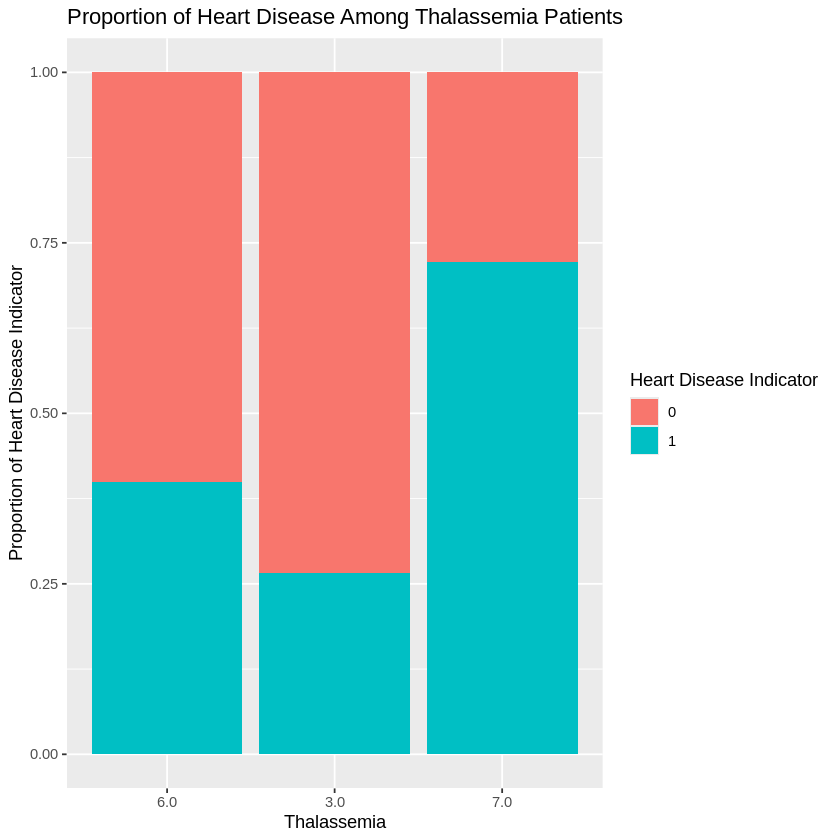

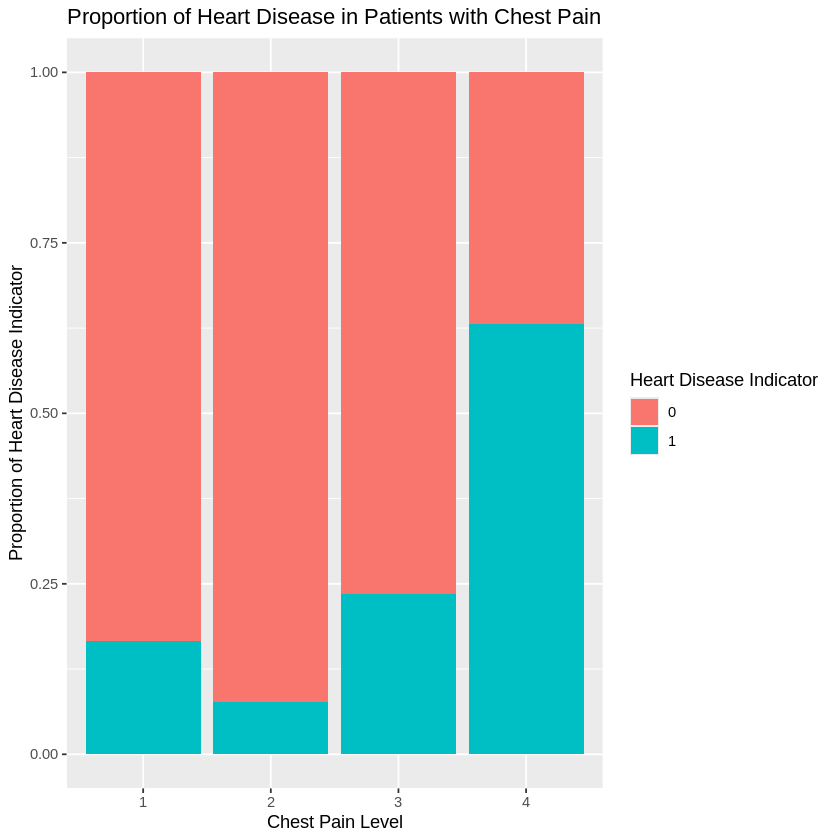

In [25]:
create_table <- function(data, column) {
    result <- data |>
        select({{ column }}, not_healthy) |> 
        group_by({{ column }}, not_healthy) |>
        summarize(count = n()) 
    return(result)
}

thal_C <- create_table(heart_disease_C_train, thal)
cp_H <- create_table(heart_disease_H_train, cp)

thal_C_plot <- thal_C |>
    ggplot(aes(x = thal, y = count, fill = not_healthy)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(x = "Thalassemia", y = "Proportion of Heart Disease Indicator", fill = "Heart Disease Indicator") +
    ggtitle("Proportion of Heart Disease Among Thalassemia Patients")
cp_H_plot <- cp_H |>
    ggplot(aes(x = cp, y = count, fill = not_healthy)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(x = "Chest Pain Level", y = "Proportion of Heart Disease Indicator", fill = "Heart Disease Indicator") +
    ggtitle("Proportion of Heart Disease in Patients with Chest Pain")
thal_C_plot
cp_H_plot

## Methods

In order to determine which features will be used in the prediction model, each individual feature will have to be analyzed to see if they have enough impact on the target class. If there is a significant split or difference between the heart disease indicators, then the feature is significant and should be considered for the model. These results will be shown through stacked bar plots for categorical features and histograms for numeric features with different colors to indicate for heart disease. Furthermore, the significant features will be used to train a predictive model, k-nearest neighbors, to predict heart disease in future patients based on prevailing data.  

## Expected Outcomes and Significant

It is expected that higher levels of blood sugar, blood pressure, and family history of related diseases will have higher contributions to determining heart disease in patients. This data model will help quantify exactly how much of each contributing factor will set the boundary between a healthy individual and a heart disease patient.

These ideas can be extended to other types of diseases including cancer, Alzheimer's, and many others. With more sophisticated models, doctors may be able to determine overlapping features between early indicators of different diseases and be able to create stronger health guidelines for current and future generations. 